In [1]:
import numpy as np
import pylab as plt
import scipy as sp
from scipy import linalg as la
import scipy.stats as stats
%matplotlib inline

In [43]:
figsize = (8,8)

In [2]:
def PSD(n,sqrt=False):
  """
  compute random positive semidefinite matrix

  input:
    n - int - dimension of matrix
    (optional)
    sqrt - bool - whether to return S such that Q = np.dot( S.T, S)

  output:
    Q - n x n - Q = Q^T,  spec Q \subset R^+
  """
  H = np.random.randn( n, n )
  d,u = np.linalg.eig( H + H.T )
  S = np.dot( u, np.dot( np.diag( np.sqrt( d*np.sign( d ) ) ), u.T ) )
  if sqrt:
    return np.dot( S.T, S ), S
  else:
    return np.dot( S.T, S )

def CT(n,margin=1e-1):
  """
  compute random stable system matrix for continuous-time linear system
    dx/dt = A x
  
  input:
    n - int - dimension of state
    
  output:
    A - n x n - spec A \subset C_o^- (open left-half complex plane)  
  """
  d,u = la.eig( np.random.randn( n, n ) )
  d.real = -np.abs(d.real)-margin
  A = np.dot( u, np.dot( np.diag(d), u.T ) )
  return A.real

def DT(n,margin=1e-1):
  """
  compute random stable system matrix for discrete-time linear system
    x^+ = A x
  
  input:
    n - int - dimension of state
    
  output:
    A - n x n - |spec A| < 1
  """
  d,u = la.eig( np.random.randn( n, n ) )
  d /= (np.abs(d).max()+margin)
  A = np.dot( u, np.dot( np.diag(d), u.T ) )
  return A.real

Consider the linear-quadratic regulation (LQR) problem for the discrete-time linear time-invariant system
$$x^+ = A x + B u$$
with infinite-horizon cost
$$J(x,u) = \frac{1}{2}\sum_{t=0}^\infty x^T Q x + u^T R u \ dt$$
where  $Q = Q^T > 0$ and $R = R^T > 0$.  We know that the optimal policy is linear in state, 
$$u = - K x,$$
where $K = (R + B^T Y B)^{-1} (B^T Y A)$ and $Y$ satisfies the discrete algebraic Riccati equation
$$Y = A^T Y A - (A^T Y B)(R + B^T Y B)^{-1}(B^T Y A) + Q.$$

In [3]:
n,m = 1,1 # dimension of continuous state, input
Q,R = PSD(n),PSD(m) # cost of state, input
A,B = DT(n),np.random.randn(n,m) # choose A stable to make our life easy

In [4]:
Y = la.solve_discrete_are(A,B,Q,R)
# optimal policy
K = np.dot( la.inv(R + np.dot( B.T, np.dot(Y, B))), 
            np.dot( B.T, np.dot( Y, A ) ) )
assert np.all(np.abs(la.eigvals(A - np.dot(B,K))) < 1),"u = - K x stabilizes x^+ = A x + B u"
# suboptimal policy
L = K + 1e-1*np.abs(K).max()*np.random.rand(m,n) # don't stray too far from optimal
assert np.all(np.abs(la.eigvals(A - np.dot(B,L))) < 1),"u = - L x stabilizes x^+ = A x + B u"

if we choose a Gaussian policy 
$$u \sim \mathcal{N}(\mu, V)$$
(or, equivalently, a deterministic policy $u = \mu$ and a Gaussian disturbance $v \sim \mathcal{N}(0, V)$)
then the state distribution after one step is also Gaussian:
$$x^+ \sim \mathcal{N}(Ax + B\mu, B V B^T).$$

In [5]:
V = PSD(m)
v = stats.multivariate_normal(mean=np.zeros(m),cov=V)

Similarly, if the state distribution starts out Gaussian, 
$$x \sim \mathcal{N}(\xi, \Sigma),$$
and we apply zero input but add a state disturbance with zero mean and covariance $W$, then (so long as the disturbance is uncorrelated with the state) the state distribution after one step is 
$$x^+ \sim \mathcal{N}(A\xi, A\Sigma A^T + W),$$
i.e. the covariance gets updated via
$$\Sigma^+ = A\Sigma A^T + W.$$
Since $A$ is stable, so long as $W$ is constant, this iteration will converge to a solution of the Lyapunov equation
$$S = A S A^T + W.$$
Also, since $A$ is stable, the steady-state mean is zero, thus we can determine the steady-state distribution in closed-form:
$$\lim_{t\rightarrow\infty} x(t) \sim \mathcal{N}(0, S).$$

In [44]:
W = PSD(n)
w = stats.multivariate_normal(mean=np.zeros(n),cov=W)
S = la.solve_discrete_lyapunov(A,W)
s = stats.multivariate_normal(mean=np.zeros(n),cov=S)
assert np.allclose( S, np.dot(A, np.dot( S, A.T )) + W )

We'll use this fact to build a finite MDP $(X,U,P,C)$:

* $X$ is a finite set of $N$ *states*
* $U$ is a finite set of $M$ *actions*
* $P:X\times U\rightarrow \Sigma(X)$ is transition probability
* $C:X\times U\times X\rightarrow \mathbb{R}$ is cost 

where $\Sigma(S) = \{p\in[0,1]^S : \sum_{s\in S} p(s) = 1\}$ is the set of probability distributions over the discrete set $S$.

In [65]:
N,M = 100,100 # number of discrete states, actions
X,U = np.random.randn(N,n),np.random.randn(M,m) # discrete states, actions
#X[0],U[0] = 0,0 # always include the origin and zero input
# TODO add meshgrid
#X,U = np.linspace(-1,1,N)[:,np.newaxis],np.linspace(-.1,.1,M)[:,np.newaxis]
# note that X & U can be any iterable
# the choice above ensures each element is also a vector, i.e. a continuous state
P = np.nan*np.zeros((N,M,N))
C = np.nan*np.zeros((N,M,N))
# loop over initial discrete state
for x_i,x in enumerate(X):
  # loop over discrete actions
  for u_i,u in enumerate(U):
    # evaluate Gaussian PDF with mean A x + B u, covariance V
    P[x_i,u_i] = w.pdf(X - ( np.dot( x, A.T ) + np.dot( u, B.T ) ))
    # generally need to loop over next discrete state
    #for _x_i,_x in enumerate(X):
    #  C[x_i,u_i,_x_i] = .5 * ( np.dot( np.dot(x, Q), x)
    #                          +np.dot( np.dot(u, R), u) )
    # but in this case cost doesn't depend on next state, so we can broadcast a scalar
    C[x_i,u_i] = .5 * ( np.dot( np.dot(x, Q), x)
                     + np.dot( np.dot(u, R), u) )
P = P / P.sum(axis=2)[...,np.newaxis] # renormalize probabilities
assert not np.any(np.isnan(P)),"all probabilities defined"
assert not np.any(np.isnan(C)),"all costs defined"

How do we know the MDP is correct?  We could check that the steady-state distributions match.  Let's apply zero input and construct the stochastic matrix $\Gamma : X \rightarrow \Sigma(X)$ by
$$\forall x,x^+\in X : \Gamma(x)(x^+) = \sum_{u\in U} \pi(x)(u) P(x,u)(x^+)$$
and treating $p$ as a row vector, we can iterate $p^+ = p \Gamma$ until convergence.

However, knowing that $\Gamma$ is a right-stochastic matrix (rows sum to 1) and assuming the MDP is *irreducible*, the unique steady-state distribution is the left eigenvector associated with the unity eigenvalue.

In [66]:
pi = np.zeros((N,M)); pi[:,0] = 1. # U[0] == 0

G = np.zeros((N,N))
for x_i,x in enumerate(X):
    for _x_i,_x in enumerate(X):
        G[x_i,_x_i] = np.sum([pi[x_i,u_i] * P[x_i,u_i,_x_i] for u_i,u in enumerate(U)])
assert np.allclose(np.sum(G,axis=1),1.)

e,El,Er = la.eig(G,left=True)
assert np.allclose(np.dot(El.T,G), (e*El).T), "rows of El.T are left eigenvectors of G"
p = El.T[np.argmax(np.abs(e))]; p /= p.sum() # p must be normalized to become a probability distribution
assert np.allclose(np.dot(p,G), p), "p is a stationary distribution"

# Q1:  Why don't the steady-state distributions match?

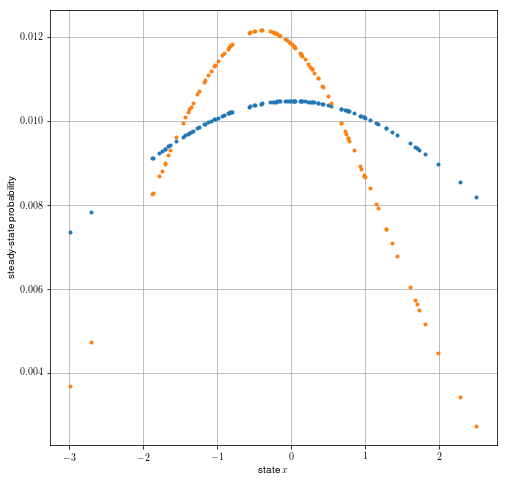

In [67]:
fig = plt.figure(figsize=figsize)

ax = plt.subplot(1,1,1); ax.grid('on')
ax.plot(X.flatten(),s.pdf(X)/s.pdf(X).sum(),'.')
ax.plot(X.flatten(),p,'.')
ax.set_ylabel('steady-state probability')
ax.set_xlabel('state $x$')

Let us now consider the problem of minimizing the infinite-horizon discounted cost
$$J = \sum_{t=0}^\infty \gamma^t c_t,$$
where $\gamma\in(0,1]$ is a *discount factor* and $c_t = C(x_t,u_t)$ is the cost at time $t$.

In the un-discounted case, $g = 1$.

In [68]:
g = 1

In [69]:
g = np.random.rand()

In [70]:
g = 0.999

In [71]:
# policy
pi = np.abs(np.random.randn(N,M)); pi = pi / np.sum(pi,axis=1)[:,np.newaxis]
assert np.allclose(np.sum(pi,axis=1),1.)

def policy_evaluation(X,U,P,C,g,pi):
    b = np.asarray([ np.sum([[pi[xi,mu] * P[xi,mu,x] * C[xi,mu,x] 
                          for x in X] for mu in U]) for xi in X])
    I = np.identity(N)
    L = I - np.asarray([ np.asarray([ np.sum([g * pi[xi,mu] * P[xi,mu,x] 
                                              for mu in U]) for x in X]) for xi in X])
    # V satisfies Bellman equation
    V = np.dot(b,la.inv(L).T)
    assert np.allclose(V, [np.sum([[pi[xi,mu] * P[xi,mu,x] * (C[xi,mu,x] + g*V[x]) 
                                for x in X] for mu in U]) for xi in X])
    return V

def policy_improvement(X,U,P,C,g,V):
    N = len(X); M = len(U)
    pi = np.zeros((N,M))
    for xi in X:
        u = np.argmin([np.sum([P[xi,mu,x]*(C[xi,mu,x] + g*V[x]) for x in X]) for mu in U])
        #assert len(u) == 1
        pi[xi,u] = 1.
    return pi

def policy_iteration(X,U,P,C,g,pi0):
    pi_ = [pi0]
    V_  = []
    while len(V_) < 2 or not(np.allclose(V_[-1],V_[-2])):
        pi = pi_[-1]
        V  = policy_evaluation(X,U,P,C,g,pi)
        _pi = policy_improvement(X,U,P,C,g,V)
        pi_.append(_pi)
        V_.append(V)
    return pi_,V_

pi_PI,V_PI = policy_iteration(range(N),range(M),P,C,g,pi)
print 'done!  %d iterations' % len(V_PI)

done!  4 iterations


# Q2:  why is there baseline drift in the value?

Unless $x = 0$, $u = 0$ are included as discrete states, policy iteration over-estimates the value by an additive constant.

In [74]:
.5*np.dot( np.dot(X[0],Y), X[0] )

1.7670514780550484

# Q3:  Why don't the value and policies match?

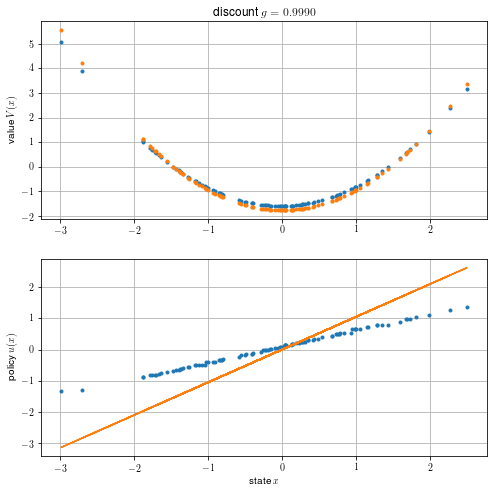

In [73]:
fig = plt.figure(figsize=figsize)

ax = plt.subplot(2,1,1); ax.grid('on')
ax.plot(X.flatten(),V_PI[-1]-V_PI[-1][0],'.')
ax.plot(X.flatten(),.5*np.diag(np.dot( np.dot(X,Y), X.T ))
                   -.5*np.dot( np.dot(X[0],Y), X[0] ),'.')
ax.set_ylabel('value $V(x)$')
ax.set_title('discount $g = %0.4f$' % g)

ax = plt.subplot(2,1,2); ax.grid('on')
ax.plot(X.flatten(),U[np.argmax(pi_PI[-1],axis=1)],'.')
ax.plot(X.flatten(),-np.dot(K,X.T).flatten())
ax.set_ylabel('policy $u(x)$')
ax.set_xlabel('state $x$')